In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json
import seaborn as sns
from datetime import datetime, timedelta

# Helper functions and variables created for the project
from helper_functions import create_bucket_df
import helper_variables

# Magic commands for visualization
%matplotlib inline

Getting the URL where the CSV file is stored in the GitHub repository

In [2]:
url = 'https://raw.githubusercontent.com/notpeter/crunchbase-data/master/companies.csv'

Loading the CSV file into a DataFrame

In [3]:
crunchbase_df = pd.read_csv(url)
crunchbase_df.to_csv('data/startup_raw_data.csv')

Initial Data Exploration

In [4]:
crunchbase_df.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


In [5]:
crunchbase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   permalink          66368 non-null  object
 1   name               66367 non-null  object
 2   homepage_url       61310 non-null  object
 3   category_list      63220 non-null  object
 4   funding_total_usd  66368 non-null  object
 5   status             66368 non-null  object
 6   country_code       59410 non-null  object
 7   state_code         57821 non-null  object
 8   region             58338 non-null  object
 9   city               58340 non-null  object
 10  funding_rounds     66368 non-null  int64 
 11  founded_at         51147 non-null  object
 12  first_funding_at   66344 non-null  object
 13  last_funding_at    66368 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.1+ MB


| Variable Name        | Description                                                  | Current Data Type | Expected Data Type  | Detected Missing Values   |
|----------------------|--------------------------------------------------------------|-------------------|---------------------|------------------|
| `permalink`          | Unique identifier for each company                           | object            | object (string)     | 0                |
| `name`               | Name of the startup                                          | object            | object (string)     | 1                |
| `homepage_url`       | Website of the company                                       | object            | object (string)     | 5058             |
| `category_list`      | Sectors or industries the company operates in                | object            | object (string)     | 3148             |
| `funding_total_usd`  | Total amount of funding received in USD                      | object            | **numeric (float/int)** | 0                |
| `status`             | Current operational status of the company (e.g., operating)  | object            | object (string)     | 0                |
| `country_code`       | Country where the company is based                           | object            | object (string)     | 6958             |
| `state_code`         | State or region within the country where the company is located | object          | object (string)     | 8547             |
| `region`             | More specific geographical designation (often a city or area) | object            | object (string)     | 8030             |
| `city`               | City where the company is based                              | object            | object (string)     | 8028             |
| `funding_rounds`     | Number of rounds of funding the company has gone through     | int64             | int64               | 0                |
| `founded_at`         | Date when the company was founded                            | object            | **datetime**            | 15221            |
| `first_funding_at`   | Date when the company received its first round of funding    | object            | **datetime**            | 24               |
| `last_funding_at`    | Date of the latest funding round                             | object            | **datetime**            | 0                |



### Name Processing

We see there is only one missing value in the name, so we can inspect it.

In [6]:
crunchbase_df[crunchbase_df['name'].isnull()]

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
56916,/organization/tell-it-in,NaN,http://tellitin10.com,Startups,25000,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01


In [7]:
crunchbase_df['name'] = crunchbase_df['name'].fillna("TellItIn")

In [8]:
crunchbase_df[crunchbase_df['name'] == 'TellItIn']

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
56916,/organization/tell-it-in,TellItIn,http://tellitin10.com,Startups,25000,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01


In [9]:
crunchbase_df[crunchbase_df['name'].isnull()]

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at


### Homepage URL

Not provided urls can be processed as not specified since we are hardly using that variable for anything

In [10]:
crunchbase_df['homepage_url'] = crunchbase_df['homepage_url'].fillna('Unkown')

### funding_total_usd Processing

Convert the Column to Numeric: Use pd.to_numeric(), setting the errors argument to 'coerce'. This will convert non-numeric values to NaN.

In [11]:
# Convert to numeric, coercing errors to NaN
numeric_column = pd.to_numeric(crunchbase_df['funding_total_usd'], errors='coerce')

# Create a boolean mask for rows that couldn't be converted (are NaN in numeric_column)
non_numeric_mask = numeric_column.isna()

# Display the original values in these rows
non_numeric_values = crunchbase_df['funding_total_usd'][non_numeric_mask]

# Check if there are any non-numeric values and display them
if non_numeric_values.empty:
    print("All values are numeric.")
else:
    print("Non-numeric values found:")
    print(non_numeric_values.unique())
    print(f'There are {len(non_numeric_values)} non-numeric values in total_funding_usd column')

Non-numeric values found:
['-']
There are 12785 non-numeric values in total_funding_usd column


In order to decid wwhat to do with the funding_total_usd column, we need to check if other data can provide us with more information about this variables, so we will be lokking at the first funding and last funding on those row and see if the dates matches. This would mean that the amount is zero sinc ethe ffirst funding equals the last funding, meaning a zero funding.

In [12]:
non_numeric_values.index

Index([    4,    10,    11,    12,    22,    33,    38,    39,    43,    45,
       ...
       66307, 66311, 66316, 66333, 66335, 66345, 66346, 66347, 66351, 66365],
      dtype='int64', length=12785)

In [13]:
# Filter the DataFrame to only include your specific rows
crhbase_filtered_df = crunchbase_df.loc[non_numeric_values.index]

# Check if the values in the two columns match
matches = crhbase_filtered_df['first_funding_at'] == crhbase_filtered_df['last_funding_at']

# You can now view or use 'matches', which is a Series of True/False values
print(f"Values matching the hypothesis: {len(matches)}")

print(f"In rows where total_funding_usd colum == '-', 'first_funding_at' and 'last_funding_at' dates are the same: -> {(len(matches) == len(non_numeric_values))}")

Values matching the hypothesis: 12785
In rows where total_funding_usd colum == '-', 'first_funding_at' and 'last_funding_at' dates are the same: -> True


This confirm the hypothesis and lt us assign those values as 0 due to the real world significance and consistency with the test

In [14]:
# Replace '-' with 0 in the specified column If you need the column to be numeric (e.g., float or int), you can convert it after replacement
crunchbase_df['funding_total_usd'] = pd.to_numeric(crunchbase_df['funding_total_usd'].replace('-', 0))

### Category List Processing

In [15]:
crunchbase_df['category_list'].unique()

array(['Media', 'Application Platforms|Real Time|Social Network Media',
       'Apps|Games|Mobile', ...,
       'Advertising|Mobile|Web Development|Wireless',
       'Consumer Electronics|Internet of Things|Telecommunications',
       'Consumer Goods|E-Commerce|Internet'], dtype=object)

In [16]:
crunchbase_df['category_list'].nunique()

27296

In [17]:
crunchbase_df['category_list'] = crunchbase_df['category_list'].fillna('Not Specified')

In [18]:
category_stack_series = crunchbase_df['category_list'].str.split('|', expand=True).stack()

In [19]:
category_one_hot_encoded = pd.get_dummies(category_stack_series, prefix=None).groupby(level=0).sum()

In [20]:
category_one_hot_encoded.head()

,3D,3D Printing,3D Technology,Accounting,Active Lifestyle,Ad Targeting,Adaptive Equipment,Advanced Materials,Adventure Travel,Advertising,...,Wine And Spirits,Wireless,Women,Writers,Young Adults,iOS,iPad,iPhone,iPod Touch,mHealth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
crunchbase_cat_df = crunchbase_df.join(category_one_hot_encoded)

In [22]:
crunchbase_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Columns: 873 entries, permalink to mHealth
dtypes: float64(1), int64(860), object(12)
memory usage: 442.0+ MB


In [23]:
crunchbase_cat_df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city',
       ...
       'Wine And Spirits', 'Wireless', 'Women', 'Writers', 'Young Adults',
       'iOS', 'iPad', 'iPhone', 'iPod Touch', 'mHealth'],
      dtype='object', length=873)

Starting from the categories column onwards

In [24]:
categories = crunchbase_cat_df.columns[14:]
categories_processed = categories.str.lower().str.replace('[^a-z0-9]', ' ', regex=True)

In [25]:
categories_processed

Index(['3d', '3d printing', '3d technology', 'accounting', 'active lifestyle',
       'ad targeting', 'adaptive equipment', 'advanced materials',
       'adventure travel', 'advertising',
       ...
       'wine and spirits', 'wireless', 'women', 'writers', 'young adults',
       'ios', 'ipad', 'iphone', 'ipod touch', 'mhealth'],
      dtype='object', length=859)

Applying basic NLP processing to explore how to handle this variable and bucket the categories in broader ones

In [26]:
vectorizer = TfidfVectorizer(stop_words='english')

In [27]:
vectorizer

TfidfVectorizer(stop_words='english')

In [28]:
X = vectorizer.fit_transform(categories_processed)

c:\Users\pablo\.conda\envs\python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


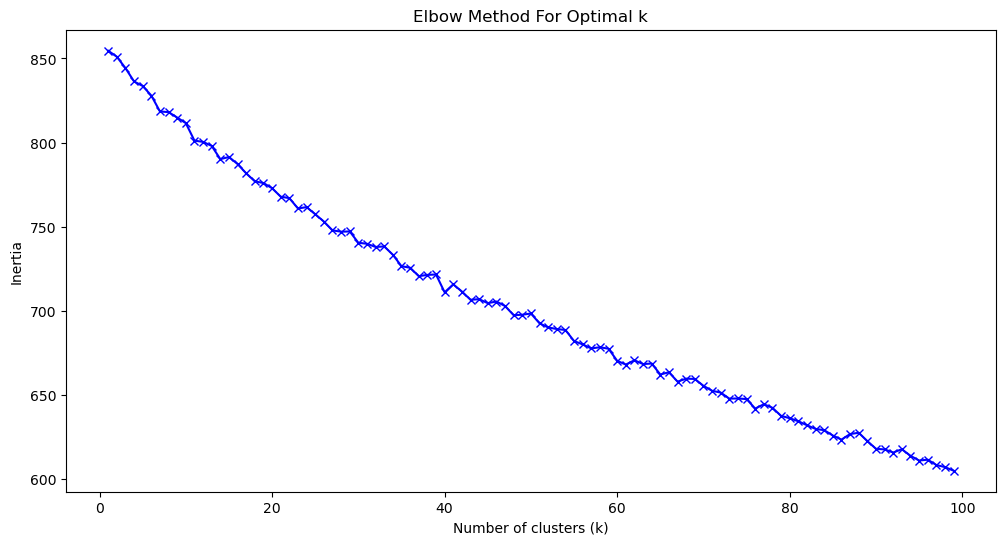

In [29]:
inertias = []
K = range(1, 100)  # Adjust the range of k as needed

# Calculate inertias for different k values
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(12, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Interpreting the Elbow Method graph involves looking for a point on the curve where the rate of decrease in inertia markedly slows down, indicating a diminishing return on the increase of the number of clusters (k). This elbow point is suggested to be the optimal number of clusters for the data.

From the provided graph, there isn't a well-defined elbow, which sometimes happens in practice. The curve is quite smooth without a clear point where the inertia's rate of decrease changes abruptly. However, there are a few observations we can make:

Gradual Decline: The inertia decreases as the number of clusters increases, which is expected. The rate of decrease is relatively smooth, suggesting that there is not a stark change in the data structure at any particular number of clusters within the range tested.

Potential Range of k: In such cases where the elbow isn't distinct, one might look for 'kinks' or 'bends' in the curve for potential elbows. It seems there might be slight bends around k=10, k=20, and k=40, though these are not sharp elbows. You might consider these points for further inspection.

Domain Knowledge: Without a clear elbow, it can be beneficial to apply domain knowledge or business understanding to decide on the number of clusters. For instance, if you know the data should naturally group into around 10-20 categories, you might choose a value in this range despite the lack of a clear elbow.

Further Analysis: It might be helpful to use other methods in conjunction with the Elbow Method. For example, you could analyze the silhouette score, which measures how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates a model with better-defined clusters.

Incremental Benefit: When the decrease in inertia begins to plateau, adding more clusters doesn't provide much additional benefit. You might select a number of clusters where this plateau starts to become more apparent, which might be around k=40 to k=60 in this case, even though the inertia continues to slowly decrease beyond this range.

Computational Cost: As the number of clusters increases, so does the computational cost. If computation time or resources are a concern, you might choose a smaller k that still captures a reasonable amount of the data structure.

In the absence of a clear elbow, it's often a judgment call, potentially informed by additional techniques and knowledge about the dataset. It's also important to remember that the Elbow Method is somewhat subjective, and the choice of k should ultimately be driven by the specific analytical goals and the interpretability of the clustering results.

In [30]:
category_list = list(categories)

In [31]:
len(category_list)

859

In [32]:
%run 2_category_bucket_creation.py

<Figure size 640x480 with 0 Axes>

In [33]:
file_path = "category_buckets.json"

# Load the JSON file into a dictionary
with open(file_path, "r") as file:
    categories_dictionary = json.load(file)

In [34]:
crhbase_bucket_df = create_bucket_df(crunchbase_cat_df, categories_dictionary)
crhbase_bucket_df = crhbase_bucket_df.drop(columns=['category_list'])

In [35]:
crhbase_bucket_df.head()

,permalink,name,homepage_url,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,Animals and Vet,"Real Estate, Property and Construction","Entertainment, Gaming and Social",Consumer Goods and Retail,Data and Cloud,Healthcare and Biotechnology,Mobile and Online Technology,"Legal, Security and Governance",Event Management and Planning,Not Specified
0,/organization/-fame,#fame,http://livfame.com,10000000.0,operating,IND,16,Mumbai,Mumbai,1,...,0,0,1,0,0,0,0,0,0,0
1,/organization/-qounter,:Qounter,http://www.qounter.com,700000.0,operating,USA,DE,DE - Other,Delaware City,2,...,0,0,1,0,0,0,1,0,0,0
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,3406878.0,operating,NaN,NaN,NaN,NaN,1,...,0,0,1,0,0,0,1,0,0,0
3,/organization/0-6-com,0-6.com,http://www.0-6.com,2000000.0,operating,CHN,22,Beijing,Beijing,1,...,0,0,0,0,0,0,1,0,0,0
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,0.0,operating,USA,IL,"Springfield, Illinois",Champaign,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
crhbase_bucket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 35 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   permalink                                                66368 non-null  object 
 1   name                                                     66368 non-null  object 
 2   homepage_url                                             66368 non-null  object 
 3   funding_total_usd                                        66368 non-null  float64
 4   status                                                   66368 non-null  object 
 5   country_code                                             59410 non-null  object 
 6   state_code                                               57821 non-null  object 
 7   region                                                   58338 non-null  object 
 8   city                      

## status Processing

Since this variable has only three different value and no nulls, we will not process it and handle it as string datatype and do initial statistical analysis and predictiva analysis. Nevertheless, a copy of a one-hot-encoded status colum on crunchbase datafaramw will be stored

In [37]:
crhbase_bucket_df['status'].unique()

array(['operating', 'acquired', 'closed', 'ipo'], dtype=object)

In [38]:
crunchbase_df = crhbase_bucket_df.copy()
crhbase_bucket_oh_status_df = pd.concat([crhbase_bucket_df.drop('status', axis=1),
                                         pd.get_dummies(crhbase_bucket_df['status'], prefix='status').astype('Int64')], axis=1)

### country_code Processing

In [39]:
crunchbase_df['country_code'].isna().sum()

6958

In [40]:
crunchbase_df['country_code'].unique()

array(['IND', 'USA', nan, 'CHN', 'HKG', 'CAN', 'CHL', 'GBR', 'FRA', 'AUS',
       'DNK', 'ROM', 'AUT', 'KOR', 'NLD', 'SWE', 'JPN', 'RUS', 'SGP',
       'NOR', 'COL', 'ESP', 'BEL', 'IRL', 'ITA', 'ISR', 'NZL', 'CZE',
       'DEU', 'CHE', 'BRA', 'BGR', 'SVN', 'JOR', 'HUN', 'BWA', 'NGA',
       'FIN', 'TUR', 'IDN', 'ARE', 'CYP', 'POL', 'CRI', 'PRT', 'ARG',
       'TWN', 'KHM', 'THA', 'SVK', 'UKR', 'LTU', 'ISL', 'ZAF', 'MEX',
       'VEN', 'URY', 'MUS', 'KEN', 'PHL', 'MNE', 'VNM', 'GHA', 'PSE',
       'MYS', 'PER', 'EGY', 'PAN', 'LVA', 'GGY', 'ALB', 'UGA', 'HRV',
       'EST', 'LBN', 'GRC', 'PAK', 'NPL', 'LUX', 'SAU', 'IRN', 'GTM',
       'BAH', 'ARM', 'BGD', 'MDA', 'SRB', 'TUN', 'ZWE', 'BRB', 'NIC',
       'TAN', 'PRI', 'TTO', 'BHR', 'CMR', 'BLR', 'CYM', 'BRN', 'ECU',
       'SLV', 'MLT', 'ZMB', 'MKD', 'GIB', 'TGO', 'LAO', 'BMU', 'HND',
       'MCO', 'MMR', 'KAZ', 'QAT', 'DOM', 'MAR', 'LIE', 'GEO', 'MOZ',
       'DZA', 'JAM', 'KNA', 'AZE', 'SEN', 'RWA', 'DMA', 'UZB', 'BLZ',
       'OMN', '

Creating a separate category for missing data in your analysis is a good approach to handle the missing country codes in your dataset.

In [41]:
# Replace NaN values in 'country_code' with a placeholder like 'Unknown' or 'Not Specified'
crunchbase_df['country_code'] = crunchbase_df['country_code'].fillna('Unknown')

During  Analysis and Visualization
In Analysis: When performing any statistical analysis or machine learning, treat 'Unknown' as a separate category. This allows you to measure the impact and distribution of missing values.

In Visualization: Especially for geographical visualization, plot the 'Unknown' data separately. If you're using a map, you might represent these data points with a separate chart (like a bar chart or pie chart) to show the proportion of missing data.

Reporting and Interpretation: When reporting your findings, clearly state that a certain percentage of data was categorized as 'Unknown' and discuss how this might impact your analysis. This is crucial for transparency and accurate interpretation of your results.

Benefits of This Approach
Maintains Data Integrity: You're not making assumptions about the missing data, thus preserving the original integrity of your dataset.

Quantifies Missingness: Allows you to quantify and report the extent of missing data, which is an essential aspect of data quality assessment.

Flexible for Various Analyses: This approach can be adapted for different types of analysis, whether it's statistical modeling, machine learning, or visualization.

### state_code, region, city Processing

Now, since the state_code, region, city will only adding granularity to the geographical analysis, we will apply the same technique to them since we do not necessarily need that level of granularity at this stage in the project 

In [42]:
# Replace NaN values in 'country_code' with a placeholder like 'Unknown' or 'Not Specified'
crunchbase_df['state_code'] = crunchbase_df['state_code'].fillna('Unknown')
# Replace NaN values in 'country_code' with a placeholder like 'Unknown' or 'Not Specified'
crunchbase_df['region'] = crunchbase_df['region'].fillna('Unknown')
# Replace NaN values in 'country_code' with a placeholder like 'Unknown' or 'Not Specified'
crunchbase_df['city'] = crunchbase_df['city'].fillna('Unknown')

### funding_rounds Processing

funding rounds variable is complete and already in int64 datetype so there is no processing needed other than basic data exploration where we see that ther a positive values ranging from 1 to 19

In [43]:
crunchbase_df['funding_rounds'].unique()

array([ 1,  2,  4,  3,  9,  5,  6,  7,  8, 10, 11, 12, 15, 13, 14, 17, 18,
       16, 19], dtype=int64)

### last_funding_at Processing

In [44]:
crunchbase_df[crunchbase_df['last_funding_at'].isna()]

,permalink,name,homepage_url,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,Animals and Vet,"Real Estate, Property and Construction","Entertainment, Gaming and Social",Consumer Goods and Retail,Data and Cloud,Healthcare and Biotechnology,Mobile and Online Technology,"Legal, Security and Governance",Event Management and Planning,Not Specified


In [45]:
# Convert the column to datetime
crunchbase_df['last_funding_at'] = pd.to_datetime(crunchbase_df['last_funding_at'])

In [46]:
crunchbase_df['last_funding_at'].max()

Timestamp('2115-12-01 00:00:00')

In [47]:
crunchbase_df[crunchbase_df['last_funding_at'] > '2023-01-01'].iloc[:, :13]

,permalink,name,homepage_url,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
46956,/organization/rasyonel-r-d,Rasyonel R&D,http://www.rasyonelarge.com,220000.0,closed,TUR,35,Izmir,Izmir,3,2013-03-20,2013-04-05,2105-05-01
63921,/organization/wigzo-technologies,Wigzo Technologies,http://www.wigzo.com/,600000.0,operating,Unknown,Unknown,Unknown,Unknown,2,NaN,2014-08-18,2115-12-01


We assume that there is an error in the data collection and that the date intended was '2015', this also considering the `first_funding_at` variable associated to the observation. In this was we will impute those values.

In [48]:
# Condition: Replace 'last_funding_at' where it's greater than '2023-01-01'
condition = crunchbase_df['last_funding_at'] > '2023-01-01'

# Replace values that meet the condition
crunchbase_df.loc[condition, 'last_funding_at'] = '2015-07-01'

In [49]:
crunchbase_df['last_funding_at'].min()

Timestamp('1971-01-01 00:00:00')

In [50]:
crunchbase_df['last_funding_at'].max()

Timestamp('2015-12-12 00:00:00')

### first_funding_at Processing

In [51]:
crunchbase_df[crunchbase_df['first_funding_at'].isna()][['funding_rounds', 'first_funding_at', 'last_funding_at', 'funding_total_usd']]

,funding_rounds,first_funding_at,last_funding_at,funding_total_usd
2445,3,NaN,2015-11-17,1.250000e+07
3334,6,NaN,2014-03-23,1.190000e+06
8029,5,NaN,2014-07-01,1.408347e+06
9843,2,NaN,2014-10-22,1.000000e+06
10204,2,NaN,2014-04-24,3.040120e+05
14717,2,NaN,2015-11-20,6.085474e+04
16250,3,NaN,2014-09-01,1.675551e+06
17589,3,NaN,2015-01-20,2.971490e+05
20101,3,NaN,2015-11-26,3.320000e+06
23422,2,NaN,2014-01-27,9.600000e+05


Method for imputation: Since we have the funding rounds and the last funding date, we can compute analysis to check on average how many months do the startups need to get 1 funding round, and then multiply the number of months to get a funsing and multiply it for the number of funding rounds, we can then later substract the number of months from the last funding date and get a goos estimation on when was the fisrt funding based on the data distribution.

In [52]:
crunchbase_df['first_funding_at'].sort_values().head()

37176    1014-03-01
22208    1201-11-23
7409     1532-06-26
61699    1960-01-01
28378    1971-01-01
Name: first_funding_at, dtype: object

In [53]:
crunchbase_ffdate_df = crunchbase_df[(crunchbase_df['first_funding_at'].notna()) & 
                                     (crunchbase_df['first_funding_at'] > '1960-01-01')]

In [54]:
crunchbase_ffdate_df['first_funding_at'].sort_values().head()

28378    1971-01-01
8786     1973-04-15
3728     1977-05-15
744      1979-01-01
36251    1980-01-01
Name: first_funding_at, dtype: object

In [55]:
# Convert 'first_funding_at' and 'last_funding_at' to datetime
crunchbase_ffdate_df['first_funding_at'] = pd.to_datetime(crunchbase_ffdate_df['first_funding_at'])

# Calculate the duration between the first and last funding in days
crunchbase_ffdate_df.loc[:, 'funding_duration_days'] = (crunchbase_ffdate_df['last_funding_at'] - crunchbase_ffdate_df['first_funding_at']).dt.days

# Handle division by zero if there are entries with zero funding rounds
crunchbase_ffdate_df.loc[crunchbase_ffdate_df['funding_rounds'] == 0, 'funding_rounds'] = 1

# Calculate the average duration per round
crunchbase_ffdate_df.loc[:, 'avg_duration_per_round'] = (crunchbase_ffdate_df['funding_duration_days'] / crunchbase_ffdate_df['funding_rounds']).round(decimals=2)

# 'avg_duration_per_round' now has the average number of days per funding round

C:\Users\pablo\AppData\Local\Temp\ipykernel_7124\1335771050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crunchbase_ffdate_df['first_funding_at'] = pd.to_datetime(crunchbase_ffdate_df['first_funding_at'])
C:\Users\pablo\AppData\Local\Temp\ipykernel_7124\1335771050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crunchbase_ffdate_df.loc[:, 'funding_duration_days'] = (crunchbase_ffdate_df['last_funding_at'] - crunchbase_ffdate_df['first_funding_at']).dt.days
C:\Users\pablo\AppData\Local\Temp\ipyker

We can confirm from our previous analysis that the startups which the first fuding is equal to the last funding date received no funding and therefore, the 'avg_duration_per_round' would be zero

In [56]:
condition_avg_zero = crunchbase_ffdate_df[crunchbase_ffdate_df['avg_duration_per_round'] == 0].index
condition_same_first_last_funding_date = crunchbase_ffdate_df[crunchbase_ffdate_df['first_funding_at'] == crunchbase_ffdate_df['last_funding_at']].index

In [57]:
len(condition_avg_zero), len(condition_same_first_last_funding_date)

(42747, 42747)

In [58]:
condition_check = list(set(condition_avg_zero) - set(condition_same_first_last_funding_date))

In [59]:
crunchbase_ffdate_df['avg_duration_per_round'].describe()

count    66340.000000
mean       110.659712
std        210.970250
min          0.000000
25%          0.000000
50%          0.000000
75%        170.500000
max       3880.000000
Name: avg_duration_per_round, dtype: float64

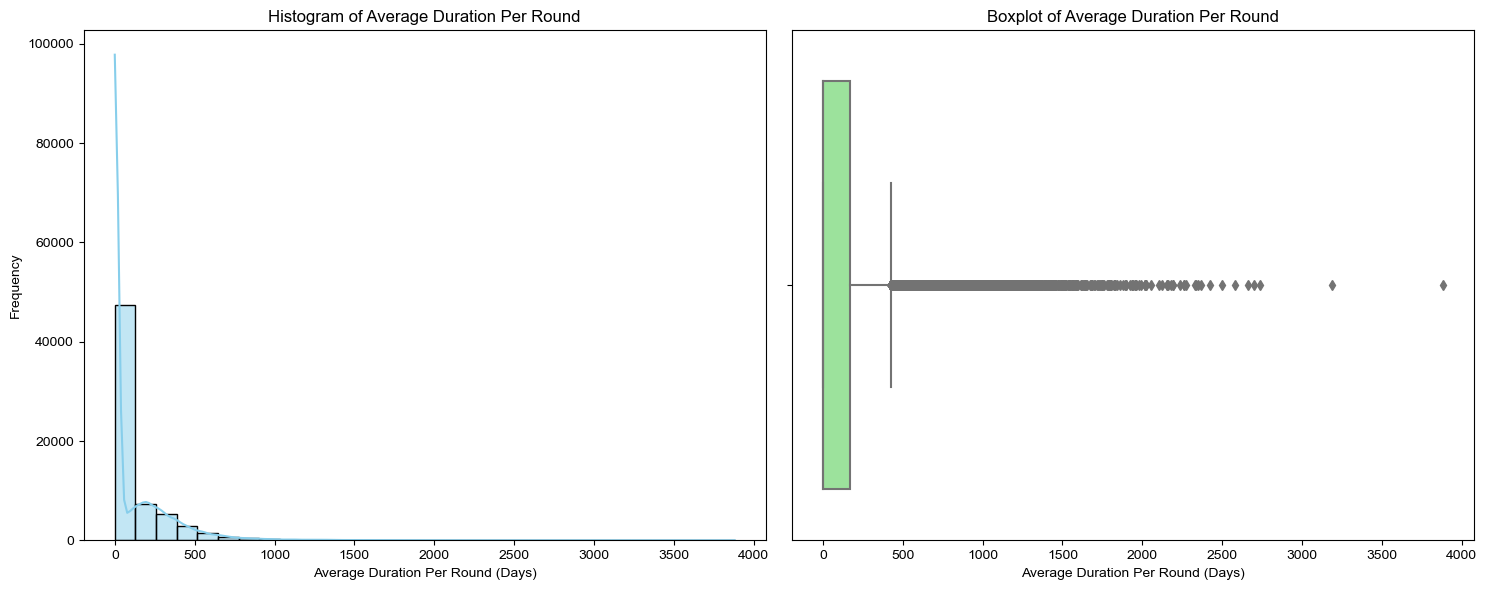

In [60]:
# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Histogram
sns.histplot(crunchbase_ffdate_df['avg_duration_per_round'], bins=30, kde=True, color="skyblue", ax=axes[0])
axes[0].set_title('Histogram of Average Duration Per Round')
axes[0].set_xlabel('Average Duration Per Round (Days)')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=crunchbase_ffdate_df['avg_duration_per_round'], ax=axes[1], color="lightgreen")
axes[1].set_title('Boxplot of Average Duration Per Round')
axes[1].set_xlabel('Average Duration Per Round (Days)')

# Aesthetic adjustments
sns.set_style("whitegrid")
plt.tight_layout()
plt.show()

We see a huge number of close to zero values, and this is because many of the startupd haven't raised any funds yet, naturally. So, for the sake of the analysis,we will just consider those average where the days are different from zero and compute the plots again

In [61]:
plot_ffdate_series = crunchbase_ffdate_df[crunchbase_ffdate_df['avg_duration_per_round'] != 0]['avg_duration_per_round']

In [62]:
plot_ffdate_series.describe()

count    23593.000000
mean       311.158619
std        250.529298
min          0.500000
25%        151.330000
50%        253.500000
75%        398.000000
max       3880.000000
Name: avg_duration_per_round, dtype: float64

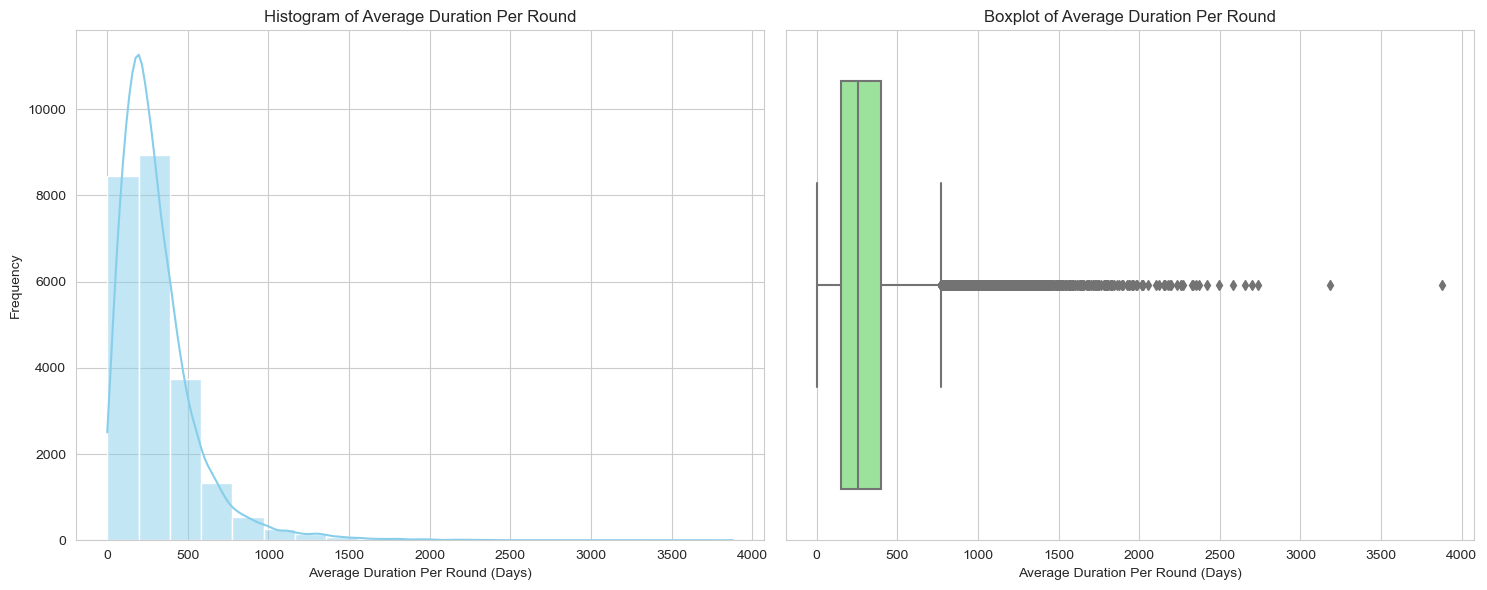

In [63]:
# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Histogram
sns.histplot(plot_ffdate_series, bins=20, kde=True, color="skyblue", ax=axes[0])
axes[0].set_title('Histogram of Average Duration Per Round')
axes[0].set_xlabel('Average Duration Per Round (Days)')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=plot_ffdate_series, ax=axes[1], color="lightgreen")
axes[1].set_title('Boxplot of Average Duration Per Round')
axes[1].set_xlabel('Average Duration Per Round (Days)')

# Aesthetic adjustments
sns.set_style("whitegrid")
plt.tight_layout()
plt.show()

Better, for the sake of simplicity, we will stick to the mean value in this case to make a calculation of the average duration per round in days times the funding rounds so we can have the number to substract from the final funding round

In [64]:
#days_to_substract = int(round(crunchbase_ffdate_df.describe()['avg_duration_per_round']['mean']))

Writing the variable to the helper file to later use

In [65]:
# Convert the variable to a string
#variable_string = f"avg_day_per_round = {days_to_substract}\n"

# Write to a Python file
#with open("helper_variables.py", "a") as file:
#    file.write(variable_string)

In [66]:
days_to_substract = helper_variables.avg_day_per_round

In [67]:
# Convert 'first_funding_at' and 'last_funding_at' to datetime
crunchbase_df['first_funding_at'] = pd.to_datetime(crunchbase_df['first_funding_at'], errors='coerce')

# Select rows where 'date_initial' is null and subtract days from 'date_column'
date_condition = crunchbase_df['first_funding_at'].isnull()
crunchbase_df.loc[date_condition, 'first_funding_at'] = crunchbase_df.loc[date_condition, 'last_funding_at'] - timedelta(days=days_to_substract) * crunchbase_df['funding_rounds']

In [68]:
crunchbase_df['first_funding_at'].min()

Timestamp('1960-01-01 00:00:00')

In [69]:
crunchbase_df['first_funding_at'].max()

Timestamp('2015-12-05 00:00:00')

### founded_at Processing

Considering funded date as the first date of funding when there are no values registered

In [70]:
crunchbase_df['founded_at'].isna().sum()

15221

The following will eliminate dates before year 1749 and assign null values to whaterver values is not able to parse as datetime

In [71]:
# Fill missing values in 'founded_at' with values from 'first_funding_at'
crunchbase_df.loc[:, 'founded_at'] = pd.to_datetime(crunchbase_df['founded_at'], errors='coerce')

In [72]:
crunchbase_df['founded_at'].sort_values().head()

49957   1749-01-01
49105   1766-01-01
60577   1785-01-01
60584   1787-01-01
22671   1789-01-01
Name: founded_at, dtype: datetime64[ns]

In [73]:
crunchbase_df['founded_at'].isna().sum()

15225

We can compute the mean in the dataset to check on average how much time the companies get their first round of funding after the date of funding and impute that value to each missing value on funding

In [74]:
crunchbase_found_date_df = crunchbase_df[(crunchbase_df['founded_at'].notna())]

In [75]:
# Fill missing values in 'founded_at' with values from 'first_funding_at'
crunchbase_found_date_df['founded_at'] = pd.to_datetime(crunchbase_found_date_df['founded_at'], errors='coerce')

C:\Users\pablo\AppData\Local\Temp\ipykernel_7124\3449671691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crunchbase_found_date_df['founded_at'] = pd.to_datetime(crunchbase_found_date_df['founded_at'], errors='coerce')


In [76]:
crunchbase_found_date_df['founded_at'].isna().sum()

0

In [77]:
crunchbase_found_date_df.loc[:, 'days'] = crunchbase_found_date_df['first_funding_at'] - crunchbase_found_date_df['founded_at']

C:\Users\pablo\AppData\Local\Temp\ipykernel_7124\2736011309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crunchbase_found_date_df.loc[:, 'days'] = crunchbase_found_date_df['first_funding_at'] - crunchbase_found_date_df['founded_at']


In [78]:
crunchbase_found_date_df['days'].dt.days

1        -187
3         443
4        1665
6        4636
7         733
         ... 
66361    2220
66362      55
66364    -194
66365    1308
66366     365
Name: days, Length: 51143, dtype: int64

We see that we have negative values for the days column and this is becaude the first_funding_at variable can be greater than the 'founded_at' column for some reason. Given this and for simplicity of analysis, we will only consider the positive values of days meaning that the 'first_funding_at' values is less than 'founded_at' value

In [79]:
crunchbase_found_date_df = crunchbase_found_date_df[crunchbase_found_date_df['days'].dt.days > 0]
crunchbase_found_date_df.loc[:, 'days'] = crunchbase_found_date_df['days'].dt.days

In [80]:
crunchbase_found_date_df['days'].describe()

count    44365.000000
mean      1605.114730
std       3755.023127
min          1.000000
25%        275.000000
50%        655.000000
75%       1600.000000
max      93053.000000
Name: days, dtype: float64

In [82]:
#days_to_substract_founded = crunchbase_found_date_df['days'].describe()['mean']

In [83]:
# Convert the variable to a string
#variable_string = f"avg_days_first_founded = {days_to_substract_founded}\n"

# Write to a Python file
#with open("helper_variables.py", "a") as file:
#    file.write(variable_string)

In [84]:
days_to_substract_founded = helper_variables.avg_days_first_founded

In [85]:
# Convert 'first_funding_at' and 'last_funding_at' to datetime
crunchbase_df['founded_at'] = pd.to_datetime(crunchbase_df['founded_at'], errors='coerce')

# Select rows where 'date_initial' is null and subtract days from 'date_column'
date_condition = crunchbase_df['founded_at'].isnull()
crunchbase_df.loc[date_condition, 'founded_at'] = crunchbase_df.loc[date_condition, 'first_funding_at'] - timedelta(days=days_to_substract_founded)

Let's explore the range of values that `founded_at`

In [86]:
crunchbase_df['founded_at'].min()

Timestamp('1749-01-01 00:00:00')

In [87]:
crunchbase_df['founded_at'].max()

Timestamp('2105-02-17 00:00:00')

We see that there are some dates that are obiously wrong, let's explore them further

In [88]:
crunchbase_df['founded_at'].sort_values().tail()

30842   2016-01-01
34438   2016-04-02
32736   2041-09-21
53396   2104-01-01
16681   2105-02-17
Name: founded_at, dtype: datetime64[ns]

We see that there are three specific dates that look like a typo on the data collection. Since they are only three of them, we will hard solve them to get a consistent dataset processed

In [89]:
# Condition: Replace 'last_funding_at' where it's greater than '2023-01-01'
condition_1 = crunchbase_df['founded_at'] == '2041-09-21'
# Replace values that meet the condition
crunchbase_df.loc[condition_1, 'founded_at'] = '2014-09-21'

# Condition: Replace 'last_funding_at' where it's greater than '2023-01-01'
condition_2 = crunchbase_df['founded_at'] == '2104-01-01'
# Replace values that meet the condition
crunchbase_df.loc[condition_2, 'founded_at'] = '2014-01-01'

# Condition: Replace 'last_funding_at' where it's greater than '2023-01-01'
condition_3 = crunchbase_df['founded_at'] == '2105-02-17'
# Replace values that meet the condition
crunchbase_df.loc[condition_3, 'founded_at'] = '2015-02-17'

Confirmation on the ranges

In [90]:
crunchbase_df['founded_at'].min()

Timestamp('1749-01-01 00:00:00')

In [91]:
crunchbase_df['founded_at'].max()

Timestamp('2016-04-02 00:00:00')

Let's see how our processed dataset looks like

In [92]:
crunchbase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 35 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   permalink                                                66368 non-null  object        
 1   name                                                     66368 non-null  object        
 2   homepage_url                                             66368 non-null  object        
 3   funding_total_usd                                        66368 non-null  float64       
 4   status                                                   66368 non-null  object        
 5   country_code                                             66368 non-null  object        
 6   state_code                                               66368 non-null  object        
 7   region                                           

In this last step, we will compilate all operations and transformations made on the notebook to a python file so we can load and process the dataset, save it as a CSV and JSON files and then load it into the next EDA jupyter notebook

In [93]:
crunchbase_df.to_csv('data/startup_processed_data.csv')

In [94]:
df_json = crunchbase_df.to_json()

with open('data/startup_processed_data.json', 'w') as file:
    json.dump(df_json, file)